In [1]:
import pandas as pd
import numpy as np
from dgutils.pandas import add_column

/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/site-packages/genome_kit/data_manager.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
sns.set(color_codes=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='ggplot')

/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
from scipy.stats import pearsonr

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
df_tr = pd.read_csv('data/training/GO:0006281_training_data_2016_0', 
                    header=None, names=['foo', 'g1', 'g2', 'fitness'], sep=' ')
df_ts = pd.read_csv('data/training/GO_0006281_testing_data_2016_0.txt', 
                    header=None, names=['foo', 'g1', 'g2', 'fitness'], sep=' ')

In [6]:
# genes in the tr/ts should be identical
genes_tr = set(df_tr.g1.unique().tolist() + df_tr.g2.unique().tolist())
genes_ts = set(df_ts.g1.unique().tolist() + df_ts.g2.unique().tolist())
print(len(genes_tr), len(genes_ts), len(genes_tr.union(genes_ts)), len(genes_tr.intersection(genes_ts)))
assert genes_tr == genes_ts

162 162 162 162


In [7]:
# tr and ts should not have the same pairs
gene_pairs_intersection = pd.merge(df_tr[['g1', 'g2']].drop_duplicates(), df_ts[['g1', 'g2']].drop_duplicates(),
                            on=['g1', 'g2'], how='inner')
gene_pairs_union = pd.merge(df_tr[['g1', 'g2']].drop_duplicates(), df_ts[['g1', 'g2']].drop_duplicates(),
                            on=['g1', 'g2'], how='outer')
print(len(gene_pairs_intersection), len(gene_pairs_union))
assert len(gene_pairs_intersection) == 0
assert len(gene_pairs_union) == len(df_tr) + len(df_ts)

0 11651


In [8]:
# encode data
gene_ids = tuple(genes_tr)  # use this to assign a unique index for each gene
num_genes = len(gene_ids)


def encode_x(g1, g2, l, gene_ids):
    x = np.ones(l)
    x[gene_ids.index(g1)] = 0
    x[gene_ids.index(g2)] = 0
    return x


df_tr = add_column(df_tr, 'x', ['g1', 'g2'], lambda g1, g2: encode_x(g1, g2, num_genes, gene_ids))
df_ts = add_column(df_ts, 'x', ['g1', 'g2'], lambda g1, g2: encode_x(g1, g2, num_genes, gene_ids))


In [9]:
# get data
x_tr = np.asarray(df_tr['x'].to_list())
y_tr = np.asarray(df_tr['fitness'].to_list())
x_ts = np.asarray(df_ts['x'].to_list())
y_ts = np.asarray(df_ts['fitness'].to_list())
print(x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape)
assert x_tr.shape[0] == y_tr.shape[0]
assert x_ts.shape[0] == y_ts.shape[0]

(8783, 162) (8783,) (2868, 162) (2868,)


In [10]:
# TODO data pre-preoceesing, y log transformation?

In [11]:
# dataset
class MyDataSet(Dataset):

    def __init__(self, x, y):
        assert x.shape[0] == y.shape[0]
        self.len = x.shape[0]
        self.x = x
        # add new axis if needed
        if len(y.shape) == 1:
            self.y = y[:, np.newaxis]
        else:
            self.y = y

    def __getitem__(self, index):
#         return self.x[index, :], self.y[index]
        return torch.from_numpy(self.x[index, :]).float(), torch.from_numpy(self.y[index]).float()

    def __len__(self):
        return self.len

In [12]:
# # a fully connected net
# class Net(nn.Module):

#     def __init__(self, n_in):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(n_in, 10)
#         self.fc2 = nn.Linear(10, 1)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [13]:
# model = torch.nn.Sequential(
#     torch.nn.Linear(num_genes, 20),
#     torch.nn.ReLU(),
#     torch.nn.Linear(20, 10),
#     torch.nn.ReLU(),
#     torch.nn.Linear(10, 5),
#     torch.nn.ReLU(),
#     torch.nn.Linear(5, 1),
# )

model = torch.nn.Sequential(
    torch.nn.Linear(num_genes, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1),
)


In [14]:
data_tr_loader = DataLoader(dataset=MyDataSet(x_tr, y_tr),
                         batch_size=200, shuffle=True)
data_ts_loader = DataLoader(dataset=MyDataSet(x_ts, y_ts),
                         batch_size=1000, shuffle=True)

In [15]:
# net = Net(num_genes)
# print(net)

In [16]:
loss_fn = torch.nn.MSELoss(reduction='mean')

In [17]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
device = torch.device("cpu")

In [19]:
# net_input = torch.randn(1, 1, 32, 32)
# net_output = net(net_input)
# target = torch.randn(10)  # a dummy target, for example
# target = target.view(1, -1)  # make it the same shape as output
# criterion = nn.MSELoss()

# loss = criterion(output, target)

In [20]:
# inital test performance
with torch.set_grad_enabled(False):
    for xt, yt in data_ts_loader:
        yt_pred = model(xt)
        loss = loss_fn(yt_pred, yt)
        print('initial test: ', loss.item())
            
for epoch in range(50):
    # Training
    for x_batch, y_batch in data_tr_loader:
        y_batch_pred = model(x_batch)
        loss = loss_fn(y_batch_pred, y_batch)
#         print(loss.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    # just print the last one for debugging
    print(loss.item())
    
    # test
    with torch.set_grad_enabled(False):
        for xt, yt in data_ts_loader:
            yt_pred = model(xt)
            loss = loss_fn(yt_pred, yt)
            print('test: ', loss.item())

initial test:  0.007324103731662035
initial test:  0.007087517064064741
initial test:  0.0078126210719347
0.005207698792219162
test:  0.004934019409120083
test:  0.008573463186621666
test:  0.006235279608517885
0.005705941002815962
test:  0.007058426737785339
test:  0.006896816194057465
test:  0.0055523645132780075
0.012177868746221066
test:  0.005445915274322033
test:  0.008009075187146664
test:  0.006057180929929018
0.0031570401042699814
test:  0.005407853052020073
test:  0.006652438547462225
test:  0.007899366319179535
0.00553158251568675
test:  0.0069696311838924885
test:  0.0066707138903439045
test:  0.005765101406723261
0.0038081491366028786
test:  0.005857149139046669
test:  0.005803273990750313
test:  0.008238769136369228
0.00621518911793828
test:  0.007661453448235989
test:  0.006473560351878405
test:  0.005358393304049969
0.010310588404536247
test:  0.006290513556450605
test:  0.007137334439903498
test:  0.005703055299818516
0.008169932290911674
test:  0.006750251166522503
te

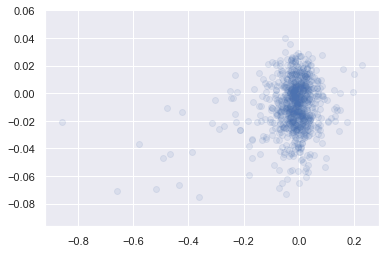

In [24]:
plt.scatter(yt, yt_pred, alpha=0.1)

In [23]:
print(pearsonr(yt, yt_pred))

(array([0.20387375], dtype=float32), array([1.3476092e-09], dtype=float32))
